In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.mixture import GaussianMixture

# Force tables to fit within ~750px
pd.set_option("display.width", 750)     # target width
pd.set_option("display.max_columns", 20)  # adjust number of columns shown



In [52]:
# Robust Cell 2: load CSV and create a boolean ValidSetup_bool column
import pandas as pd
from IPython.display import display, HTML

csv_file = "CandleRangeData_NZDUSD_H4.csv"   # <- set your filename here
df = pd.read_csv(csv_file, sep=None, engine="python")
print("Loaded rows:", len(df))
print("Columns found:", list(df.columns))

# Inject CSS to ensure tables are never wider than 750px
display(HTML("""
<style>
.dataframe {
    max-width: 750px;
    overflow-x: auto;
    display: block;
}
</style>
"""))

# Show first 5 rows (auto-fits within 750px)
display(df.head())

# Try to detect a 'valid setup' column (several common name variants)
candidates = ["ValidSetup", "validsetup", "Valid_Setup", "Valid", "valid", "ValidSetup_bool", "Valid_Setup_bool"]
found = None
for c in candidates:
    if c in df.columns:
        found = c
        break

# Case-insensitive detection if exact not found
if found is None:
    lower_map = {col.lower(): col for col in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            found = lower_map[c.lower()]
            break

# Create boolean column 'ValidSetup_bool' using detected column or fallback
if found is not None:
    print("Using column for validity:", found)
    series = df[found].astype(str).str.strip().str.lower()
    df["ValidSetup_bool"] = series.isin(["true", "1", "yes", "y", "t"])
else:
    print("No ValidSetup-like column found. Creating ValidSetup_bool=True for all rows (no filtering).")
    df["ValidSetup_bool"] = True

# Quick stats
total = len(df)
valid_count = df["ValidSetup_bool"].sum()
print(f"Total rows = {total}, ValidSetup_bool True = {valid_count}")

# Create df_valid for downstream cells (the rest of notebook expects df_valid)
df_valid = df[df["ValidSetup_bool"] == True].copy()
print("df_valid rows:", len(df_valid))

# Display preview (will respect 750px width)
display(df_valid.head())


Loaded rows: 547
Columns found: ['Symbol', 'Timeframe', 'ObsTime', 'RefTop', 'RefBot', 'Range', 'RefDir', 'Ext', 'RetracePips', 'RetracePct', 'Type', 'SeqType', 'InsideCount', 'LookaheadUsed', 'GapSize', 'HighMomentum', 'SameDirSupport', 'NearestFibPct', 'NearestFibDistPct', 'ValidSetup', 'InvalidReason', 'Volume', 'Spread_pips']


Symbol Timeframe              ObsTime   RefTop   RefBot    Range RefDir      Ext  RetracePips  RetracePct  ... LookaheadUsed GapSize  HighMomentum  SameDirSupport  NearestFibPct  NearestFibDistPct  ValidSetup  InvalidReason  Volume  Spread_pips
0  NZDUSD        H4  2025-10-01T12:00:00  0.58197  0.57977  0.00220   Bull  0.58021        176.0     80.0000  ...             1     0.0             0            True           78.6             1.4000        True            NaN   12737        125.0
1  NZDUSD        H4  2025-10-01T00:00:00  0.58011  0.57911  0.00100   Bear  0.57981         70.0     70.0000  ...             1     0.0             0            True           61.8             8.2000        True            NaN    3960        125.0
2  NZDUSD        H4  2025-09-30T08:00:00  0.57931  0.57751  0.00180   Bull  0.57832         99.0     55.0000  ...             1     0.0             0            True           50.0             5.0000        True            NaN   11037        125.0
3  NZDUSD        H4  2025-09-30T04:00:00  0.57795  0.57702  0.00093   Bull  0.57751         44.0     47.3118  ...             1     0.0             0            True           50.0             2.6882        True            NaN    6755        125.0
4  NZDUSD        H4  2025-09-29T20:00:00  0.57890  0.57783  0.00107   Bear  0.57822         39.0     36.4486  ...             1     0.0             0            True           38.2             1.7514        True            NaN    2538        125.0

[5 rows x 23 columns]

Using column for validity: ValidSetup
Total rows = 547, ValidSetup_bool True = 547
df_valid rows: 547


Symbol Timeframe              ObsTime   RefTop   RefBot    Range RefDir      Ext  RetracePips  RetracePct  ... GapSize HighMomentum  SameDirSupport  NearestFibPct  NearestFibDistPct  ValidSetup  InvalidReason  Volume  Spread_pips  ValidSetup_bool
0  NZDUSD        H4  2025-10-01T12:00:00  0.58197  0.57977  0.00220   Bull  0.58021        176.0     80.0000  ...     0.0            0            True           78.6             1.4000        True            NaN   12737        125.0             True
1  NZDUSD        H4  2025-10-01T00:00:00  0.58011  0.57911  0.00100   Bear  0.57981         70.0     70.0000  ...     0.0            0            True           61.8             8.2000        True            NaN    3960        125.0             True
2  NZDUSD        H4  2025-09-30T08:00:00  0.57931  0.57751  0.00180   Bull  0.57832         99.0     55.0000  ...     0.0            0            True           50.0             5.0000        True            NaN   11037        125.0             True
3  NZDUSD        H4  2025-09-30T04:00:00  0.57795  0.57702  0.00093   Bull  0.57751         44.0     47.3118  ...     0.0            0            True           50.0             2.6882        True            NaN    6755        125.0             True
4  NZDUSD        H4  2025-09-29T20:00:00  0.57890  0.57783  0.00107   Bear  0.57822         39.0     36.4486  ...     0.0            0            True           38.2             1.7514        True            NaN    2538        125.0             True

[5 rows x 24 columns]

In [53]:
# Cell 3: Compute retracement values based on the collector's schema

# In our MT5 output:
# - RefTop = top of the reference bar
# - RefBot = bottom of the reference bar
# - Ext    = the extreme retracement reached before close
# - RetracementPct = retracement % already computed in MT5

# 1. Use the collector's "Range" directly
df_valid["Range"] = df_valid["Range"].astype(float)

# 2. Use the already provided retracement percentage (if available)
if "RetracementPct" in df_valid.columns:
    df_valid["Retracement"] = df_valid["RetracementPct"].astype(float) / 100.0
    print("Using MT5-calculated RetracementPct column.")
else:
    # fallback: compute from RefTop/RefBot and Ext
    df_valid["Retracement"] = (df_valid["Ext"].astype(float) - df_valid["RefBot"].astype(float)) / df_valid["Range"]
    print("No RetracementPct column found — computed from RefTop/RefBot/Ext.")

# 3. Clip between 0 and 1 (0%–100%)
df_valid["Retracement"] = df_valid["Retracement"].clip(0, 1)

# Quick check
print("Preview of retracement values:")
display(df_valid[["RefTop","RefBot","Ext","Range","Retracement"]].head())


No RetracementPct column found — computed from RefTop/RefBot/Ext.
Preview of retracement values:


RefTop   RefBot      Ext    Range  Retracement
0  0.58197  0.57977  0.58021  0.00220     0.200000
1  0.58011  0.57911  0.57981  0.00100     0.700000
2  0.57931  0.57751  0.57832  0.00180     0.450000
3  0.57795  0.57702  0.57751  0.00093     0.526882
4  0.57890  0.57783  0.57822  0.00107     0.364486

Plotting 547 retracement observations (0..1 scale).


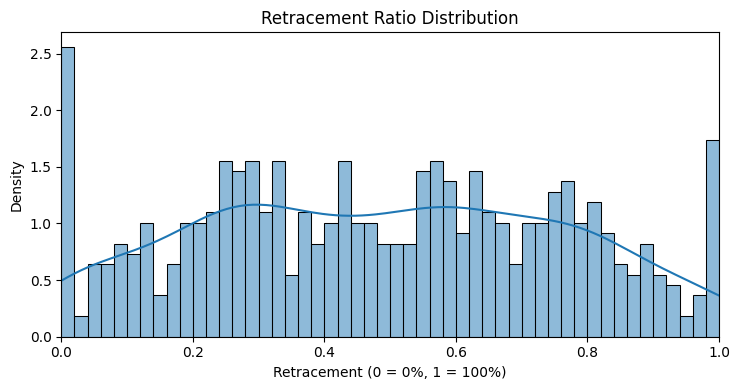

In [54]:
# Plotting cell 4 (robust): ensures 'Retracement' exists and draws a 750px-wide plot
import numpy as np
import matplotlib.pyplot as plt

# --- Build 'Retracement' column if needed ---
if "Retracement" not in df_valid.columns:
    if "RetracementPct" in df_valid.columns:
        # MT5 already computed it as percent (0-100)
        df_valid["Retracement"] = pd.to_numeric(df_valid["RetracementPct"], errors="coerce") / 100.0
        print("Using existing RetracementPct -> created Retracement (0-1).")
    else:
        # try to compute from RefTop/RefBot/Ext with direction awareness
        required = {"RefTop","RefBot","Ext","RefDir"}
        if required.issubset(set(df_valid.columns)):
            def compute_r(row):
                try:
                    rng = float(row["RefTop"]) - float(row["RefBot"])
                    if rng == 0: 
                        return np.nan
                    if str(row["RefDir"]).strip().lower().startswith("b") :  # Bull
                        return (float(row["RefTop"]) - float(row["Ext"])) / rng
                    elif str(row["RefDir"]).strip().lower().startswith("be"): # Bear (or 'bear')
                        return (float(row["Ext"]) - float(row["RefBot"])) / rng
                    else:
                        return np.nan
                except Exception:
                    return np.nan
            df_valid["Retracement"] = df_valid.apply(compute_r, axis=1).astype(float)
            print("Computed Retracement from RefTop/RefBot/Ext/RefDir.")
        else:
            raise KeyError("No 'Retracement' or 'RetracementPct' column, and required columns for computation are missing. "
                           "Found columns: " + ", ".join(df_valid.columns))

# Clip to 0..1
df_valid["Retracement"] = df_valid["Retracement"].clip(lower=0.0, upper=1.0)

# Drop NaNs
vals = df_valid["Retracement"].dropna().values
if len(vals) == 0:
    raise ValueError("No valid retracement values to plot after preprocessing.")

print(f"Plotting {len(vals)} retracement observations (0..1 scale).")

# --- Plot size: target ~750 px width ---
# Use figsize such that width_inches * dpi = 750. We'll choose dpi=100, width=7.5in.
fig_w, fig_h = 7.5, 4.0
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=100)

# Prefer seaborn if available for nice KDE overlay, otherwise fallback
try:
    import seaborn as sns
    sns.histplot(vals, bins=50, stat="density", kde=True, ax=ax)
except Exception:
    # fallback to matplotlib
    ax.hist(vals, bins=50, density=True, alpha=0.6)
    # manual KDE overlay
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(vals)
    xgrid = np.linspace(0,1,500)
    ax.plot(xgrid, kde(xgrid), linewidth=2)

ax.set_title("Retracement Ratio Distribution")
ax.set_xlabel("Retracement (0 = 0%, 1 = 100%)")
ax.set_ylabel("Density")
ax.set_xlim(0,1)
plt.tight_layout()

# Optionally save a sized PNG (uncomment to save)
# plt.savefig("retracement_distribution_750px.png", dpi=100)

plt.show()


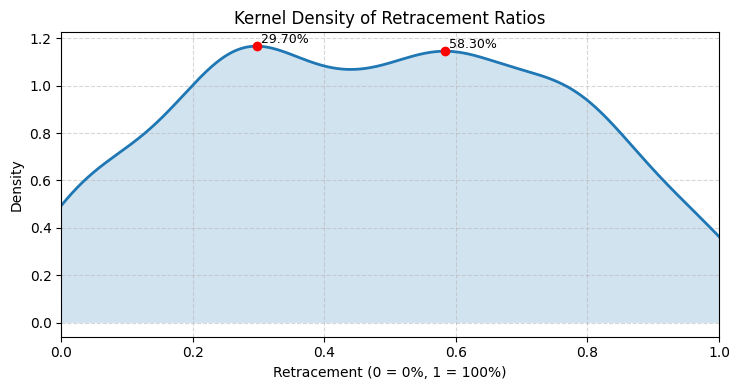

Candidate Hidden Retracement Levels (%):
[29.7 58.3]
Peak prominences (relative): [0.5762 0.0659]


In [55]:
# KDE + peak detection (robust, ~750px wide output)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks

# --- ensure Retracement column exists (0..1 scale) ---
if "Retracement" not in df_valid.columns:
    if "RetracementPct" in df_valid.columns:
        df_valid["Retracement"] = pd.to_numeric(df_valid["RetracementPct"], errors="coerce") / 100.0
    else:
        required = {"RefTop","RefBot","Ext","RefDir"}
        if required.issubset(set(df_valid.columns)):
            def compute_r(row):
                try:
                    rng = float(row["RefTop"]) - float(row["RefBot"])
                    if rng == 0:
                        return np.nan
                    rd = str(row["RefDir"]).strip().lower()
                    if rd.startswith("b"):  # Bull
                        return (float(row["RefTop"]) - float(row["Ext"])) / rng
                    elif rd.startswith("be") or rd.startswith("bear"):  # Bear
                        return (float(row["Ext"]) - float(row["RefBot"])) / rng
                    else:
                        return np.nan
                except Exception:
                    return np.nan
            df_valid["Retracement"] = df_valid.apply(compute_r, axis=1).astype(float)
        else:
            raise KeyError("Cannot build 'Retracement' — missing required columns. Found: " + ", ".join(df_valid.columns))

# Clip and drop NaNs
df_valid["Retracement"] = df_valid["Retracement"].clip(0,1)
vals = df_valid["Retracement"].dropna().values
n = len(vals)
if n < 10:
    raise ValueError(f"Too few retracement observations to compute KDE/peaks reliably (n={n}).")

# --- KDE on a fine grid ---
grid = np.linspace(0, 1, 1001)   # 0.001 (0.1%) resolution
kde = stats.gaussian_kde(vals)
dens = kde(grid)

# --- peak detection on normalized density ---
dens_norm = dens / dens.max()
peaks_idx, props = find_peaks(dens_norm, prominence=0.02, distance=8)  # tweak params as needed
peak_levels = grid[peaks_idx]
peak_heights = dens[peaks_idx]

# --- Plot (750px wide) ---
fig_w, fig_h, dpi = 7.5, 4.0, 100  # 7.5in * 100dpi = 750px width
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
ax.plot(grid, dens, label="KDE", linewidth=2)
ax.fill_between(grid, dens, alpha=0.2)

# annotate peaks
for lvl, h in zip(peak_levels, peak_heights):
    ax.plot(lvl, h, "o", color="red")
    ax.text(lvl, h, f" {lvl*100:.2f}%", va="bottom", ha="left", fontsize=9)

ax.set_title("Kernel Density of Retracement Ratios")
ax.set_xlabel("Retracement (0 = 0%, 1 = 100%)")
ax.set_ylabel("Density")
ax.set_xlim(0,1)
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# optionally save exact-750px PNG (uncomment to save)
# plt.savefig("kde_retracement_750px.png", dpi=dpi)

plt.show()

# --- print candidate levels ---
print("Candidate Hidden Retracement Levels (%):")
print(np.round(peak_levels*100, 2))
print("Peak prominences (relative):", np.round(props["prominences"], 4) if "prominences" in props else "n/a")

In [56]:
# Preparatory check: make sure df_valid["Retracement"] exists and has enough samples
import numpy as np
import pandas as pd

if "Retracement" not in df_valid.columns:
    if "RetracementPct" in df_valid.columns:
        df_valid["Retracement"] = pd.to_numeric(df_valid["RetracementPct"], errors="coerce")/100.0
    else:
        raise KeyError("No 'Retracement' or 'RetracementPct' column available. Compute retracement first.")

# drop nans and guard minimum sample size
vals = df_valid["Retracement"].dropna().values
n = len(vals)
print("Observations (retracements):", n)
if n < 50:
    print("Warning: very small sample size; tests will be unreliable. Consider increasing data or relaxing filters.")


Observations (retracements): 547


In [57]:
from scipy import stats

# KS test against Uniform(0,1)
# We use one-sample KS by comparing empirical CDF to uniform CDF.
ks_stat, ks_p = stats.kstest(vals, 'uniform', args=(0,1))
print(f"KS statistic = {ks_stat:.4f}, p-value = {ks_p:.4g}")

# Interpretation:
# - p < 0.05: reject the null that retracements are uniform -> structure exists.
# - p >= 0.05: cannot reject uniformity (no evidence of clustering), but absence of evidence is not proof of uniformity.


KS statistic = 0.0570, p-value = 0.05516


In [58]:
# Chi-square goodness of fit (binned)
bins = np.linspace(0, 1, 51)  # 50 bins of width 2% (adjust as needed)
hist_counts, _ = np.histogram(vals, bins=bins)
expected = np.ones_like(hist_counts) * (len(vals) / len(hist_counts))

chi2_stat = ((hist_counts - expected)**2 / expected).sum()
df_chi = len(hist_counts) - 1
from scipy.stats import chi2
chi2_p = 1 - chi2.cdf(chi2_stat, df_chi)

print(f"Chi2 stat = {chi2_stat:.2f}, df = {df_chi}, p-value = {chi2_p:.4g}")

# Interpretation:
# - p < 0.05: reject uniformity at the chosen bin resolution.
# - Change bin count to test different resolutions; coarse bins check large-scale departures, fine bins pick fine structure.


Chi2 stat = 104.46, df = 49, p-value = 6.853e-06


In [59]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import math
import time

# Parameters (tweak)
grid = np.linspace(0,1,2001)          # KDE evaluation grid (0.05% resolution)
kde_bw_method = None                  # None => scipy default; or set like 0.2 etc.
peak_prominence = 0.02                # relative to max density (0.02 = 2% of max)
min_separation_pct = 0.5              # minimum separation between peaks in percent points (0.5% default)
window_pct = 0.8                      # window size (percent) around peak for mass calculation, e.g. 0.8 -> ±0.4%
bootstrap_iters = 1000                # bootstrap iterations (500-2000 typical)
random_seed = 0

# Build KDE and find peaks
kde = gaussian_kde(vals, bw_method=kde_bw_method)
dens = kde(grid)
# normalize density so max==1 for prominence thresholding
dens_norm = dens / dens.max()

# find peaks
dist_pts = max(1, int((min_separation_pct/100.0) * len(grid)))  # convert separation pct -> grid points
peaks_idx, props = find_peaks(dens_norm, prominence=peak_prominence, distance=dist_pts)
peak_positions = grid[peaks_idx]
peak_heights = dens[peaks_idx]
print("Detected peaks at (pct):", np.round(peak_positions*100,3))

# helper: compute KDE mass in the window centered at level (window_pct percent)
def mass_in_window(kde_obj, level, grid, window_pct):
    half = window_pct/2.0/100.0  # convert percent -> fraction
    left = level - half
    right = level + half
    mask = (grid >= left) & (grid <= right)
    return kde_obj(grid[mask]).sum() * (grid[1]-grid[0])  # approximate integral by sum*dx

# observed masses
observed_masses = {}
for lvl in peak_positions:
    m = mass_in_window(kde, lvl, grid, window_pct)
    observed_masses[lvl] = m

# bootstrap
rng = np.random.default_rng(random_seed)
bootstrap_masses = {lvl: [] for lvl in peak_positions}

t0 = time.time()
for i in range(bootstrap_iters):
    sample = rng.choice(vals, size=len(vals), replace=True)
    kde_b = gaussian_kde(sample, bw_method=kde_bw_method)
    for lvl in peak_positions:
        m = mass_in_window(kde_b, lvl, grid, window_pct)
        bootstrap_masses[lvl].append(m)
    if (i+1) % 200 == 0:
        print(f"Bootstrap {i+1}/{bootstrap_iters}...")

t1 = time.time()
print(f"Bootstrap done in {t1-t0:.1f}s")

# compute empirical p-values: fraction of bootstrap masses >= observed mass
pvals = {}
for lvl in peak_positions:
    arr = np.array(bootstrap_masses[lvl])
    obs = observed_masses[lvl]
    p = (arr >= obs).sum() / len(arr)
    pvals[lvl] = p

# Multiple testing correction (Benjamini-Hochberg)
levels = list(peak_positions)
pvals_list = np.array([pvals[l] for l in levels])
m = len(pvals_list)
order = np.argsort(pvals_list)
sorted_p = pvals_list[order]
bh_thresh = (np.arange(1,m+1) / m) * 0.05  # FDR 5%
rejected = np.zeros(m, dtype=bool)
for i, pval in enumerate(sorted_p):
    if pval <= bh_thresh[i]:
        rejected[i] = True
# map back to original order
rejected_orig = np.zeros(m, dtype=bool)
rejected_orig[order] = rejected

# Summarize results
print("\nPeak testing results (window ±{:.2f}%):".format(window_pct/2))
for i, lvl in enumerate(levels):
    print(f"Level {lvl*100:.3f}%  mass={observed_masses[lvl]:.6e}  p={pvals[lvl]:.4f}   significant={bool(rejected_orig[i])}")

# Collect final accepted levels
accepted = [lvl for i,lvl in enumerate(levels) if rejected_orig[i]]
print("\nAccepted (FDR<0.05) candidate levels (pct):", np.round(np.array(accepted)*100,3))


Detected peaks at (pct): [29.7 58.3]
Bootstrap 200/1000...
Bootstrap 400/1000...
Bootstrap 600/1000...
Bootstrap 800/1000...
Bootstrap 1000/1000...
Bootstrap done in 4.5s

Peak testing results (window ±0.40%):
Level 29.700%  mass=9.909890e-03  p=0.4960   significant=False
Level 58.300%  mass=9.729858e-03  p=0.4960   significant=False

Accepted (FDR<0.05) candidate levels (pct): []


In [49]:
gmm = GaussianMixture(n_components=5, random_state=42).fit(df_valid["Retracement"].values.reshape(-1,1))
centers = gmm.means_.flatten()
print("GMM Hidden Level Centers (%):", np.round(centers*100, 2))


GMM Hidden Level Centers (%): [ 76.18  37.53  18.2  100.    55.18]


In [51]:
results = pd.DataFrame({
    "HiddenLevel": np.round(hidden_levels*100, 2)
})
results.to_csv("HiddenFiboLevels.csv", index=False)
print("Saved hidden levels to HiddenFiboLevels.csv")


Saved hidden levels to HiddenFiboLevels.csv
